In [1]:
import os
os.chdir(r'C:\Users\DELL\Personal Project\Supervised_Learning\Classifier')

In [2]:
from SVM import SVM

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, hinge_loss, make_scorer
from sklearn.pipeline import Pipeline

# Import dataset

In [4]:
data = fetch_covtype()
print(data.DESCR)

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

=================   ============
Classes                        7
Samples total             581012
Dimensionality                54
Features                     int
=================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional argument 'as_frame' is
se

In [5]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df[data.target_names[0]] = data.target
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydrology      581012 non-null  float64
 5   Horizontal_Distance_To_Roadways     581012 non-null  float64
 6   Hillshade_9am                       581012 non-null  float64
 7   Hillshade_Noon                      581012 non-null  float64
 8   Hillshade_3pm                       581012 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  float64
 10  Wilderness_Area_0                   581012 non-null  float64
 11  Wilderness_Area_1         

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Soil_Type_0,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


# EDA

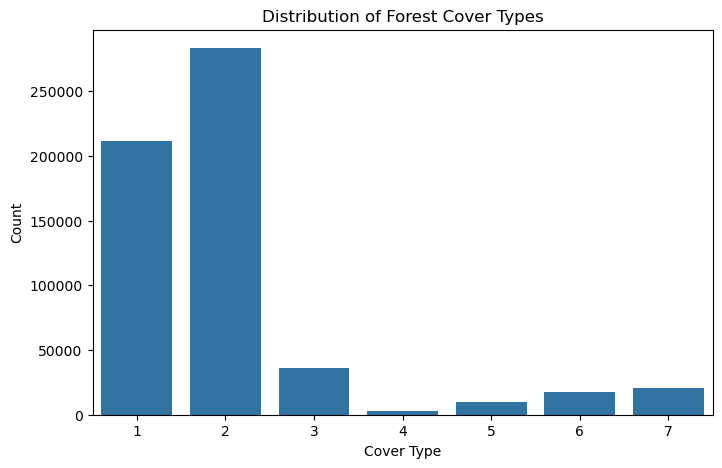

Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64


In [6]:
# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Cover_Type"])
plt.title("Distribution of Forest Cover Types")
plt.xlabel("Cover Type")
plt.ylabel("Count")
plt.show()

# Print class counts
print(df["Cover_Type"].value_counts())

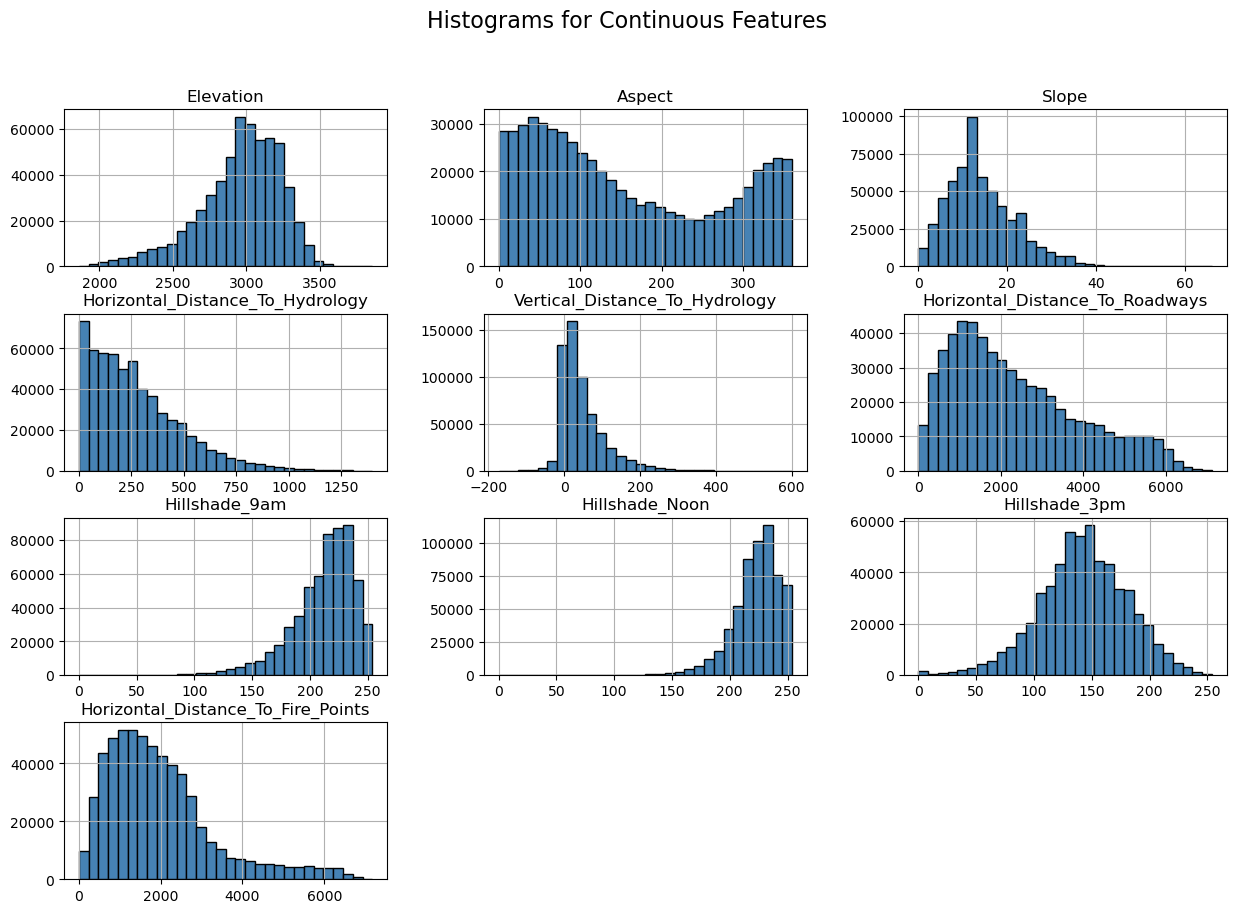

Skewness of Continuous Features:
Elevation                            -0.817596
Aspect                                0.402628
Slope                                 0.789273
Horizontal_Distance_To_Hydrology      1.140437
Vertical_Distance_To_Hydrology        1.790250
Horizontal_Distance_To_Roadways       0.713679
Hillshade_9am                        -1.181147
Hillshade_Noon                       -1.063056
Hillshade_3pm                        -0.277053
Horizontal_Distance_To_Fire_Points    1.288644
dtype: float64


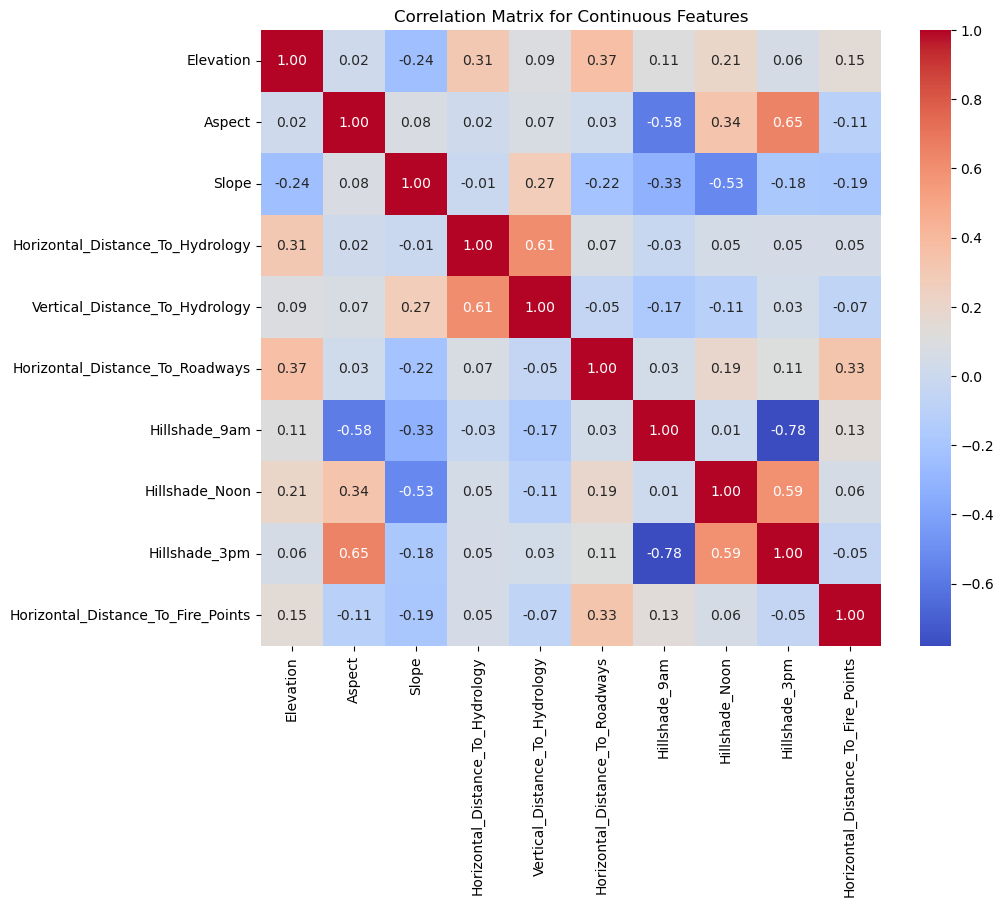

In [7]:
continuous_cols = df.columns[:10]
# Histograms for continuous features
df[continuous_cols].hist(bins=30, figsize=(15, 10), color='steelblue', edgecolor='black')
plt.suptitle("Histograms for Continuous Features", fontsize=16)
plt.show()

# Calculate skewness for all continuous features (first 10 columns)
skewness = df.iloc[:, :10].skew()
print("Skewness of Continuous Features:")
print(skewness)

# Correlation matrix for continuous features
corr_matrix = df[continuous_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Continuous Features")
plt.show()

transform skewness on whole dataset
choose subset similar to original dataset, visual to confirm
train sklearn model on both datasets to evaluate
improve performance 
apply all the techniques to self made model on subset 

# Building model

## Split into training and test sets 

> The entire dataset is too large. To save time, only 1% of the dataset is used to train the model, instead of 70 or 80% as usual . However, the training dataset should be representative of the original dataset.

In [8]:
X, y = df.drop(columns = ['Cover_Type']), df['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, stratify=y, random_state=42)
training_set = pd.DataFrame(X_train, columns=data.feature_names)
training_set[data.target_names[0]] = y_train

## Visualize the training set

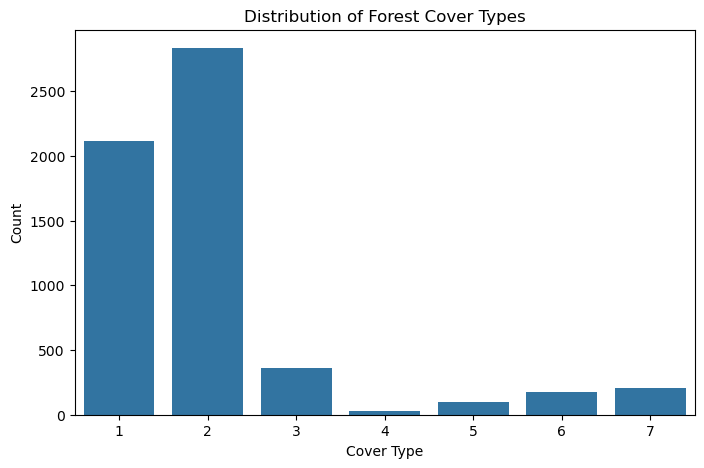

Cover_Type
2    2833
1    2118
3     358
7     205
6     174
5      95
4      27
Name: count, dtype: int64


In [9]:
# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=training_set["Cover_Type"])
plt.title("Distribution of Forest Cover Types")
plt.xlabel("Cover Type")
plt.ylabel("Count")
plt.show()

# Print class counts
print(training_set["Cover_Type"].value_counts())

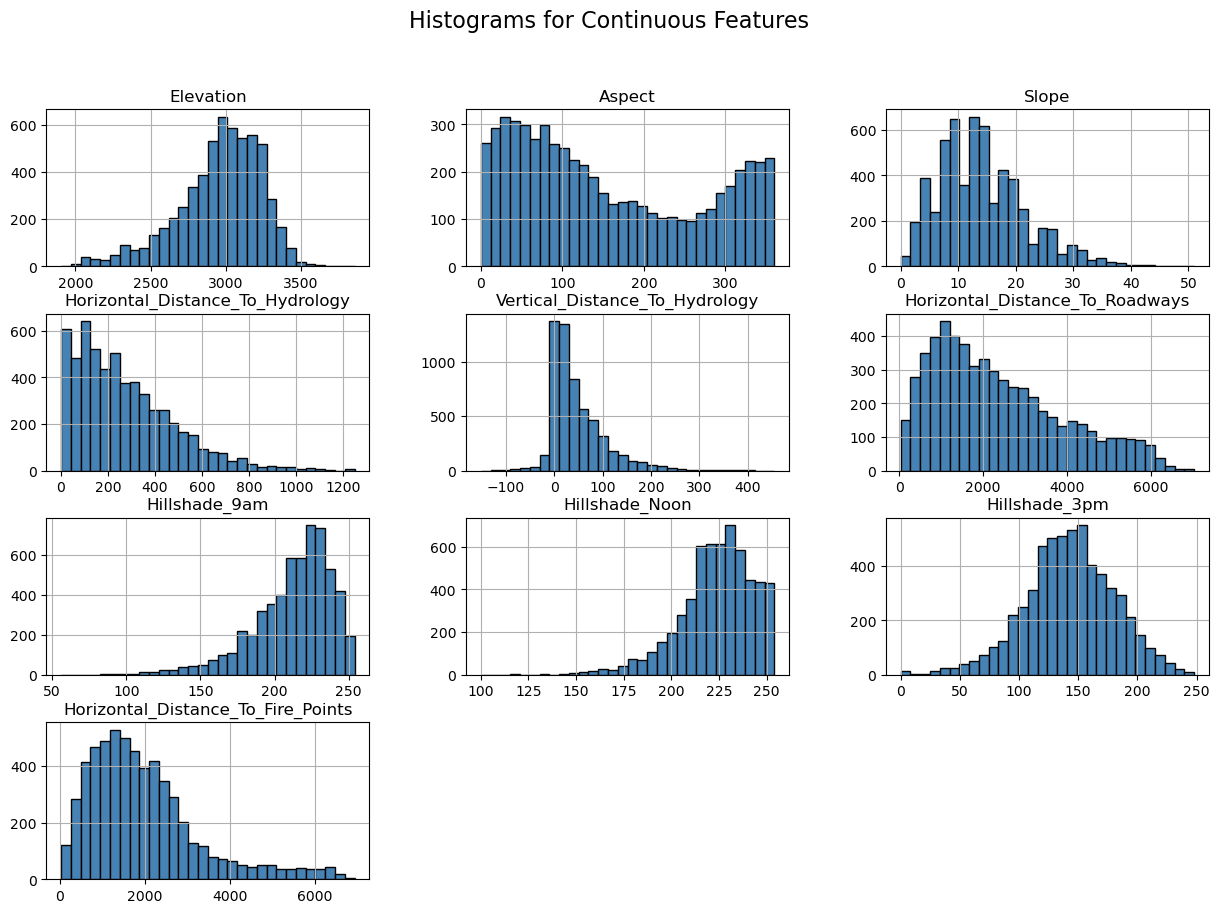

Skewness of Continuous Features:
Elevation                            -0.811785
Aspect                                0.407470
Slope                                 0.812895
Horizontal_Distance_To_Hydrology      1.125119
Vertical_Distance_To_Hydrology        1.712202
Horizontal_Distance_To_Roadways       0.706201
Hillshade_9am                        -1.225160
Hillshade_Noon                       -1.065629
Hillshade_3pm                        -0.275085
Horizontal_Distance_To_Fire_Points    1.329167
dtype: float64


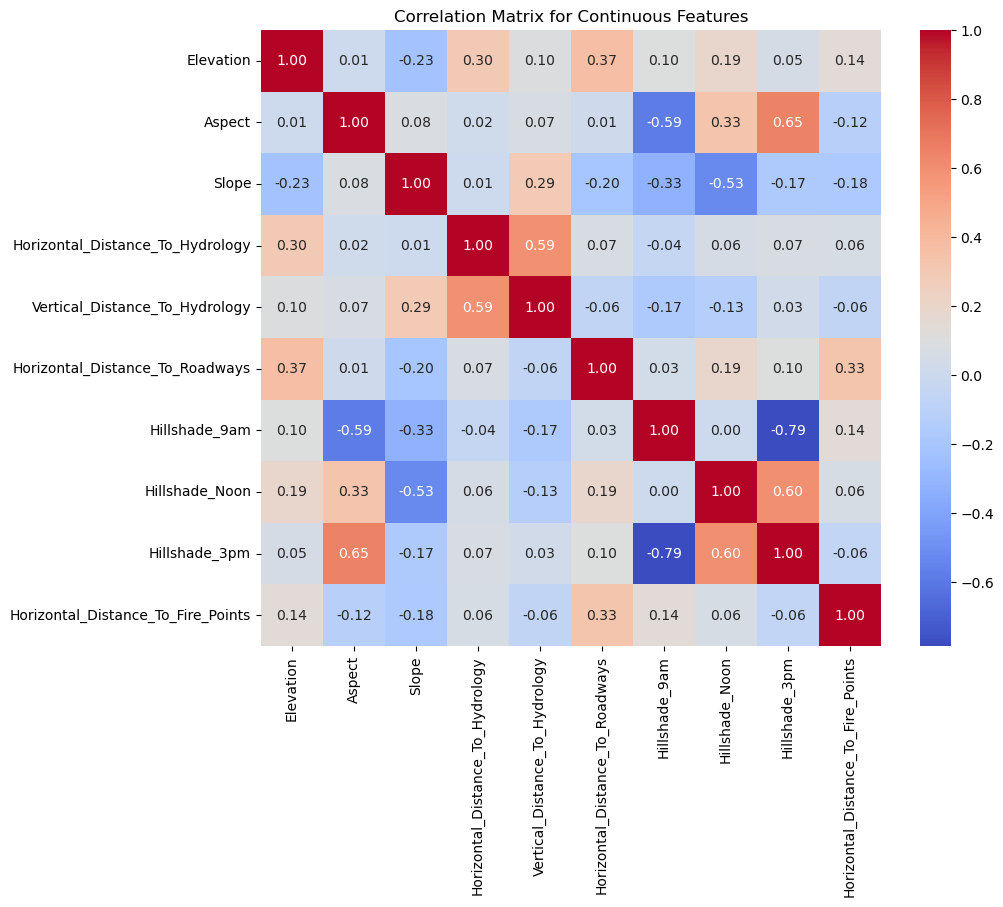

In [10]:
continuous_cols = training_set.columns[:10]
# Histograms for continuous features
training_set[continuous_cols].hist(bins=30, figsize=(15, 10), color='steelblue', edgecolor='black')
plt.suptitle("Histograms for Continuous Features", fontsize=16)
plt.show()

# Calculate skewness for all continuous features (first 10 columns)
skewness = training_set.iloc[:, :10].skew()
print("Skewness of Continuous Features:")
print(skewness)

# Correlation matrix for continuous features
corr_matrix = training_set[continuous_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Continuous Features")
plt.show()

> The visualization shows the similarity between the training data and the original data.

## Function to evaluate the model

In [11]:
def evaluate_multiclass(y_true, y_pred_decision, y_pred):
    # Compute Hinge Loss
    loss = hinge_loss(y_true, y_pred_decision)
    print(f'Hinge Loss: {loss:.4f}\n')

    # Print Classification Report (Ensuring all classes are considered)
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Compute Confusion 
    print("Confusion_matrix:")
    print(confusion_matrix(y_true, y_pred))

##  SVM Model

In [13]:
svm_pl = Pipeline([
    ('scaler', StandardScaler()),  
    ('rbf_svm', SVM(kernel='rbf'))  
])
svm_pl.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -1.9285e+03 -1.4231e+04  5e+04  2e+00  2e-15
 1: -1.7383e+03 -8.9031e+03  7e+03  5e-14  7e-16
 2: -1.9061e+03 -2.9980e+03  1e+03  8e-14  7e-16
 3: -2.0371e+03 -2.2617e+03  2e+02  6e-14  6e-16
 4: -2.0711e+03 -2.1105e+03  4e+01  9e-14  5e-16
 5: -2.0775e+03 -2.0843e+03  7e+00  4e-14  5e-16
 6: -2.0787e+03 -2.0795e+03  9e-01  3e-14  5e-16
 7: -2.0788e+03 -2.0789e+03  8e-02  3e-15  4e-16
 8: -2.0789e+03 -2.0789e+03  2e-03  4e-14  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0622e+03 -1.4178e+04  5e+04  2e+00  2e-15
 1: -1.8555e+03 -9.2960e+03  8e+03  1e-02  6e-16
 2: -2.0349e+03 -3.0782e+03  1e+03  2e-03  7e-16
 3: -2.1835e+03 -2.4178e+03  2e+02  3e-04  5e-16
 4: -2.2248e+03 -2.2704e+03  5e+01  4e-05  5e-16
 5: -2.2335e+03 -2.2412e+03  8e+00  4e-06  5e-16
 6: -2.2351e+03 -2.2359e+03  8e-01  3e-07  5e-16
 7: -2.2352e+03 -2.2353e+03  6e-02  2e-08  5e-16
 8: -2.2353e+03 -2.2353e+03  2e-03  6e-10  4e-1

Pipeline(steps=[('scaler', StandardScaler()),
                ('rbf_svm', <SVM.SVM object at 0x0000029C43788C50>)])

In [16]:
random_indices = np.random.choice(X_test.shape[0], size=10000, replace=False)
X_test = X_test.iloc[random_indices]
y_test = y_test.iloc[random_indices]

In [17]:
y_pred_decision = svm_pl.decision_function(X_test)
y_pred = svm_pl.predict(X_test)
evaluate_multiclass(y_test, y_pred_decision, y_pred)

Hinge Loss: 0.6274

Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.69      0.72      3569
           2       0.71      0.84      0.77      4929
           3       0.71      0.57      0.63       641
           4       0.60      0.14      0.23        43
           5       0.55      0.26      0.35       184
           6       0.51      0.30      0.38       287
           7       0.82      0.45      0.58       347

    accuracy                           0.72     10000
   macro avg       0.67      0.46      0.52     10000
weighted avg       0.72      0.72      0.72     10000

Confusion_matrix:
[[2458 1067    5    0    3    5   31]
 [ 689 4123   51    0   32   30    4]
 [   0  230  363    4    0   44    0]
 [   0   25   11    6    0    1    0]
 [  19  114    2    0   48    1    0]
 [   1  118   79    0    4   85    0]
 [  79  113    0    0    0    0  155]]


## Compare to model of sklearn

In [17]:
from sklearn.svm import SVC

pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('svc', SVC(class_weight='balanced'))
])

pipeline.fit(X_train, y_train)

y_pred_decision = pipeline.decision_function(X_test)
y_pred = pipeline.predict(X_test)
evaluate_multiclass(y_test, y_pred_decision, y_pred)

Hinge Loss: 0.8338

Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.69      0.69      3687
           2       0.80      0.57      0.67      4853
           3       0.67      0.60      0.64       594
           4       0.30      0.79      0.43        43
           5       0.13      0.70      0.21       158
           6       0.33      0.65      0.44       310
           7       0.44      0.86      0.58       355

    accuracy                           0.63     10000
   macro avg       0.48      0.70      0.52     10000
weighted avg       0.71      0.63      0.65     10000

Confusion_matrix:
[[2531  649    3    0  108   37  359]
 [1106 2774   85    7  623  230   28]
 [   0    9  358   57   32  138    0]
 [   0    0    5   34    0    4    0]
 [   5   30    2    0  111   10    0]
 [   2    5   78   16    6  203    0]
 [  51    0    0    0    0    0  304]]


> The sklearn model performs worse in terms of both hinge loss and accuracy. It also has worse precision but better recall 

# Summary
The model using One vs Rest strategy takes a lot of time to run, because each binary svm also has a very long run time. Storing binary svm models also takes a lot of memory so it cannot predict for too large dataset.

Recommendations to Improve Performance:

    1. **Try others regularization parameters and kernel**  
    2. **Feature Transformation and Engineering**  
    3. **Try other Ensemble Methods**  
    4. **Over/Undersampling**
    4. **Try Different Type of Classification Models**  